In [1]:
import pandas as pd
pd.options.display.max_columns=200
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.pipeline import make_pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import plotly.express as px
from sklearn.metrics import adjusted_rand_score

In [2]:
data = pd.read_csv('data.csv')

In [3]:
data.drop(['Unnamed: 0'], axis=1, inplace=True)
data.head()

,customer_id,customer_unique_id,order_id,price,order_purchase_timestamp
0,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,29.99,2017-10-02 10:56:33
1,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,118.70,2018-07-24 20:41:37
2,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,159.90,2018-08-08 08:38:49
3,f88197465ea7920adcdbec7375364d82,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,45.00,2017-11-18 19:28:06
4,8ab97904e6daea8866dbdbc4fb7aad2c,72632f0f9dd73dfee390c9b22eb56dd6,ad21c59c0840e6cb83a9ceb5573f8159,19.90,2018-02-13 21:18:39


In [4]:
#separate data for each week
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'])

data['week'] = (data['order_purchase_timestamp'] - data['order_purchase_timestamp'].min()).dt.days // 7

In [5]:
data['order_purchase_timestamp'].min()

Timestamp('2016-09-04 21:15:19')

In [6]:
data.loc[data['order_purchase_timestamp'] == '2016-09-04 21:15:19']

,customer_id,customer_unique_id,order_id,price,order_purchase_timestamp,week
4510,08c5351a6aca1c1589a38f244edeee9d,b7d76e111c89f7ebf14761390f0f7d17,2e7a8482f6fb09756ca50c10d7bfc047,39.99,2016-09-04 21:15:19,0


In [7]:
data.sort_values(by='order_purchase_timestamp', inplace=True)

In [8]:
data['week'].max()

104

In [9]:
data.head()

,customer_id,customer_unique_id,order_id,price,order_purchase_timestamp,week
4510,08c5351a6aca1c1589a38f244edeee9d,b7d76e111c89f7ebf14761390f0f7d17,2e7a8482f6fb09756ca50c10d7bfc047,39.99,2016-09-04 21:15:19,0
4366,683c54fc24d40ee9f8a6fc179fd9856c,4854e9b3feff728c13ee5fc7d1547e92,e5fa5a7210941f7d56d0208e4e071d35,59.50,2016-09-05 00:15:34,0
30475,86dc2ffce2dfff336de2f386a786e574,830d5b7aaa3b6f1e9ad63703bec97d23,bfbd0f9bdef84302105ad712db648a6c,44.99,2016-09-15 12:16:38,1
82428,b106b360fe2ef8849fbbd056f777b4d5,0eb1ee9dba87f5b36b4613a65074337c,71303d7e93b399f5bcd537d124c0bcfa,100.00,2016-10-02 22:07:52,4
92566,355077684019f7f60a031656bd7262b8,32ea3bdedab835c3aa6cb68ce66565ef,3b697a20d9e427646d92567910af6d57,29.90,2016-10-03 09:44:50,4


In [10]:
#Create a dictionnary of dataframes
data_week = {}

#For i number of week in range of 2 years 
for i in range(0, 105):
    data_week[i] = data.loc[data['week']<=i]
    #Calculate amount spent
    data_week[i]['amount_spent'] = data_week[i].groupby('customer_unique_id')['price'].transform('sum')
    #Calculate fraquency
    data_week[i]['frequency'] = data_week[i].groupby('customer_unique_id')['order_id'].transform('count')
    #Calculate recency
    data_week[i]['recency'] = data_week[i].groupby('customer_unique_id')['order_purchase_timestamp'].transform('max')
    data_week[i]['recency'] = (data_week[i]['order_purchase_timestamp'].max() - data_week[i]['recency']).dt.days    
    data_week[i].sort_values('recency', ascending=False, inplace=True)
    #Unify for customer
    data_week[i].drop_duplicates(subset='customer_unique_id', keep='last', inplace=True)
    data_week[i] = data_week[i][['customer_unique_id', 'recency', 'frequency', 'amount_spent']]    

In [11]:
data_week[104].loc[data_week[104]['frequency'] > 1]

,customer_unique_id,recency,frequency,amount_spent
31416,f7b62c75467e8ce080b201667cbbc274,696,2,90.87
27699,7a176e5d88c7acb6000a055e008c055d,694,2,489.89
92977,0ecf7f65b5ff3b9e61b637e59f495e0a,692,2,68.89
930,12f5d6e1cbf93dafd9dcc19095df0b3d,605,6,58.40
236,f7be9bec658c62ab6240b44cd26c0b84,605,2,20.80
...,...,...,...,...
95162,e0836a97eaae86ac4adc26fbb334a527,6,3,62.98
60398,1041688b50cfd8ef6df6086a1746a30c,5,2,41.80
22181,fb7e29c65321441231990afc201c1b14,5,2,182.90
38446,34b0cd95480e55c2a701293a2b9671b3,5,3,153.31


In [12]:
data.loc[data['customer_unique_id'] == 'e0836a97eaae86ac4adc26fbb334a527']

,customer_id,customer_unique_id,order_id,price,order_purchase_timestamp,week
95093,f63b99a7b32694f5b1f0a4171478cd21,e0836a97eaae86ac4adc26fbb334a527,c765302c18a92bcea0bc5c976bae0174,14.49,2018-06-26 14:03:15,94
37371,f7224426a8a68eda1674c2b84be34da2,e0836a97eaae86ac4adc26fbb334a527,67d3db1e6d9adab9c49e67e8a2e65b8f,14.49,2018-07-30 07:41:38,99
95162,15aee229d1d48b6a17dd0b8e2a3705e0,e0836a97eaae86ac4adc26fbb334a527,c7756342d355d13eea40a754b6602da6,34.00,2018-08-27 09:54:35,103


In [13]:
data_week[94].loc[data_week[94]['customer_unique_id'] == 'e0836a97eaae86ac4adc26fbb334a527']

,customer_unique_id,recency,frequency,amount_spent
95093,e0836a97eaae86ac4adc26fbb334a527,5,1,14.49


In [14]:
data_week[103].loc[data_week[103]['customer_unique_id'] == 'e0836a97eaae86ac4adc26fbb334a527']

,customer_unique_id,recency,frequency,amount_spent
37371,e0836a97eaae86ac4adc26fbb334a527,2,3,62.98


In [15]:
data_week[104]

,customer_unique_id,recency,frequency,amount_spent
4510,b7d76e111c89f7ebf14761390f0f7d17,728,1,39.99
4366,4854e9b3feff728c13ee5fc7d1547e92,728,1,59.50
30475,830d5b7aaa3b6f1e9ad63703bec97d23,717,1,44.99
82428,0eb1ee9dba87f5b36b4613a65074337c,700,1,100.00
87779,8d3a54507421dbd2ce0a1d58046826e0,699,1,119.90
...,...,...,...,...
74174,b4dcade04bc548b7e3b0243c801f8c26,4,1,99.00
67309,0421e7a23f21e5d54efed456aedbc513,4,1,109.90
5729,21dbe8eabd00b34492a939c540e2b1a7,4,1,6.90
87719,0c6d7218d5f3fa14514fd29865269993,4,1,169.80


In [16]:
for i in range(0, 105):
      data_week[i].set_index('customer_unique_id', inplace=True)

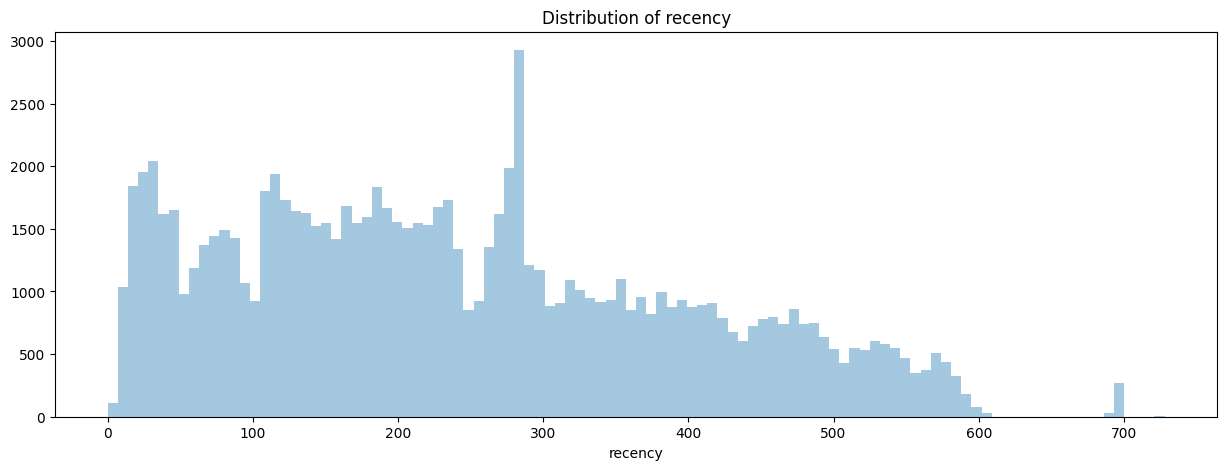

In [17]:
#plot distribution of recency
plt.figure(figsize=(15, 5))
sns.distplot(data_week[104]['recency'], kde=False, bins=104)
plt.title('Distribution of recency')
plt.show()

In [18]:
#Scaler on every data_week
data_week_scaled = {}
for i in range(0, 105):
    scaler = StandardScaler()
    data_week_scaled[i] = scaler.fit_transform(data_week[i])

In [19]:
#Apply kmeans on every data_week
kmeans_week = {}

for i in range(0, 105):
    if data_week_scaled[i].shape[0] > 4:
            kmeans_week[i] = KMeans(n_clusters=4, random_state=42)
            kmeans_week[i].fit(data_week_scaled[i])
            data_week[i]['cluster'] = kmeans_week[i].labels_

In [20]:
data_week[104][:data_week[103].shape[0]]['cluster']

customer_unique_id
b7d76e111c89f7ebf14761390f0f7d17    1
4854e9b3feff728c13ee5fc7d1547e92    1
830d5b7aaa3b6f1e9ad63703bec97d23    1
0eb1ee9dba87f5b36b4613a65074337c    1
8d3a54507421dbd2ce0a1d58046826e0    1
                                   ..
b4dcade04bc548b7e3b0243c801f8c26    0
0421e7a23f21e5d54efed456aedbc513    0
21dbe8eabd00b34492a939c540e2b1a7    0
0c6d7218d5f3fa14514fd29865269993    0
ff22e30958c13ffe219db7d711e8f564    2
Name: cluster, Length: 95420, dtype: int32

In [21]:
data_week[103]['cluster']

customer_unique_id
b7d76e111c89f7ebf14761390f0f7d17    0
4854e9b3feff728c13ee5fc7d1547e92    0
830d5b7aaa3b6f1e9ad63703bec97d23    0
0eb1ee9dba87f5b36b4613a65074337c    0
30a38716bb2d04f12bb813aa2f926270    0
                                   ..
bb5d40ed8c3448238563262b4700bae5    1
23e6a9d387ba03e2099233222d7635cf    1
fb7e29c65321441231990afc201c1b14    2
1041688b50cfd8ef6df6086a1746a30c    2
24ac2b4327e25baf39f2119e4228976a    1
Name: cluster, Length: 95420, dtype: int32

In [22]:
adjusted_rand_score(data_week[51]['cluster'], data_week[104][:data_week[51].shape[0]]['cluster'])

-0.0008505793574933483

In [38]:
kmeans_week[52].predict(data_week_scaled[55])

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [40]:
#Try with weeks since 1 year
ari_range = {}
for s in range(1, 53):
    ari_range[s] = adjusted_rand_score(data_week[52+s]['cluster'], kmeans_week[52].predict(data_week_scaled[52+s]))

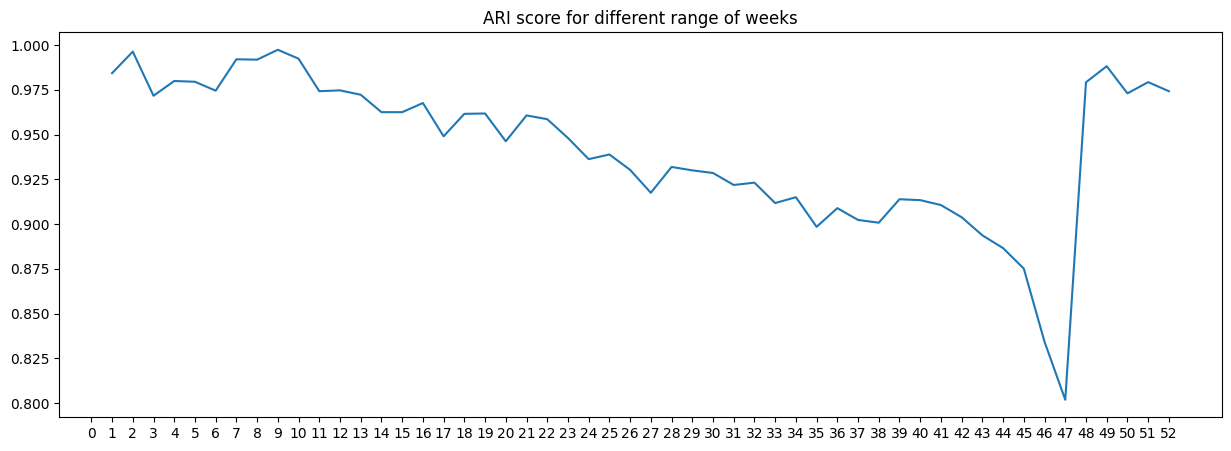

In [41]:
#plot ARI score for different range of weeks
plt.figure(figsize=(15, 5))
plt.plot(list(ari_range.keys()), list(ari_range.values()))
plt.xticks(np.arange(0, 53, 1))
plt.title('ARI score for different range of weeks')
plt.show()

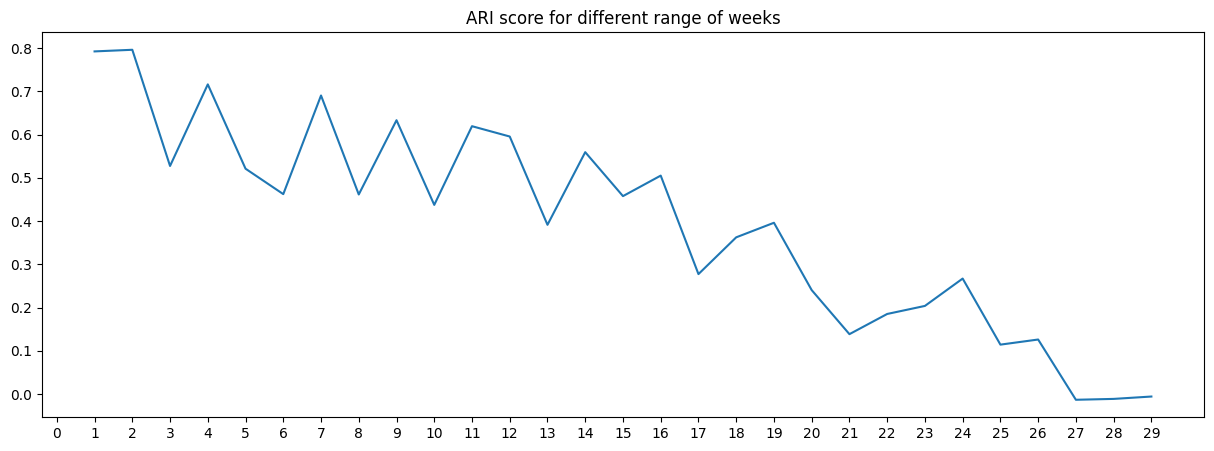

In [25]:
#Second try with every weeks
ari_range = {}
for s in range(1, 30):
    for i in range (0, 105-s, s):
        ari = []
        if data_week_scaled[i].shape[0] > 4:
            ari.append(adjusted_rand_score(data_week[i]['cluster'], data_week[i+s][:data_week[i].shape[0]]['cluster']))
    ari_range[s] = np.mean(ari)
    
#plot ARI score for different range of weeks
plt.figure(figsize=(15, 5))
plt.plot(list(ari_range.keys()), list(ari_range.values()))
plt.xticks(np.arange(0, 30, 1))
plt.title('ARI score for different range of weeks')
plt.show()